# Fairness Results

In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.grid'] = True

In [3]:
def load_fairness_results(results_dir):
    """
    Load all fairness_*.json files from the directory and return two DataFrames:
    """
    results_dir = Path(results_dir)
    json_files = sorted(results_dir.glob("fairness_*.json"))

    global_rows = []
    group_rows = []

    for path in json_files:
        with path.open("r") as f:
            data = json.load(f)

        dataset = data.get("dataset")
        protected_attr = data.get("protected_attr")
        dp = bool(data.get("dp"))
        model_type = data.get("model_type", "")

        gm = data["global_metrics"]
        global_rows.append(
            {
                "file": path.name,
                "dataset": dataset,
                "protected_attr": protected_attr,
                "dp": dp,
                "model_type": model_type,
                "accuracy_overall": gm["accuracy_overall"],
                "ks_stat": gm["ks_stat"],
                "ks_pvalue": gm["ks_pvalue"],
                "welch_t_stat": gm["welch_t_stat"],
                "welch_t_pvalue": gm["welch_t_pvalue"],
                "tv_distance": gm["tv_distance"],
                "epsilon_empirical": gm["epsilon_empirical"],
            }
        )


    global_df = pd.DataFrame(global_rows)
    return global_df

In [4]:
RESULTS_DIR = "results" 

global_df = load_fairness_results(RESULTS_DIR)

print("Global metrics:")
global_df

Global metrics:


,file,dataset,protected_attr,dp,model_type,accuracy_overall,ks_stat,ks_pvalue,welch_t_stat,welch_t_pvalue,tv_distance,epsilon_empirical
0,fairness_adult_gender_dpFalse.json,adult,gender,False,logreg,0.791487,0.001769,1.000000,0.030332,0.975803,0.000138,0.230468
1,fairness_adult_gender_dpTrue.json,adult,gender,True,logreg,0.772029,0.000774,1.000000,0.003250,0.997407,0.000032,0.007813
2,fairness_adult_race_dpFalse.json,adult,race,False,logreg,0.789165,0.017137,0.140388,-1.045543,0.295786,0.004055,0.582272
3,fairness_adult_race_dpTrue.json,adult,race,True,logreg,0.765395,0.004091,0.999999,0.052381,0.958226,0.000078,0.522461
4,fairness_compas_gender_dpFalse.json,compas,gender,False,logreg,0.943874,0.005013,0.997826,0.127648,0.898429,0.001250,0.076355
5,fairness_compas_gender_dpTrue.json,compas,gender,True,logreg,0.696935,0.000740,1.000000,-0.004176,0.996668,0.000011,0.003174
6,fairness_compas_race_dpFalse.json,compas,race,False,logreg,0.442354,0.013477,0.217153,2.441536,0.014632,0.030962,3.122559
7,fairness_compas_race_dpTrue.json,compas,race,True,logreg,0.687731,0.004273,0.999871,-0.006837,0.994545,0.000068,0.046017


## Global comparison: accuracy and ε by dataset / attribute / DP

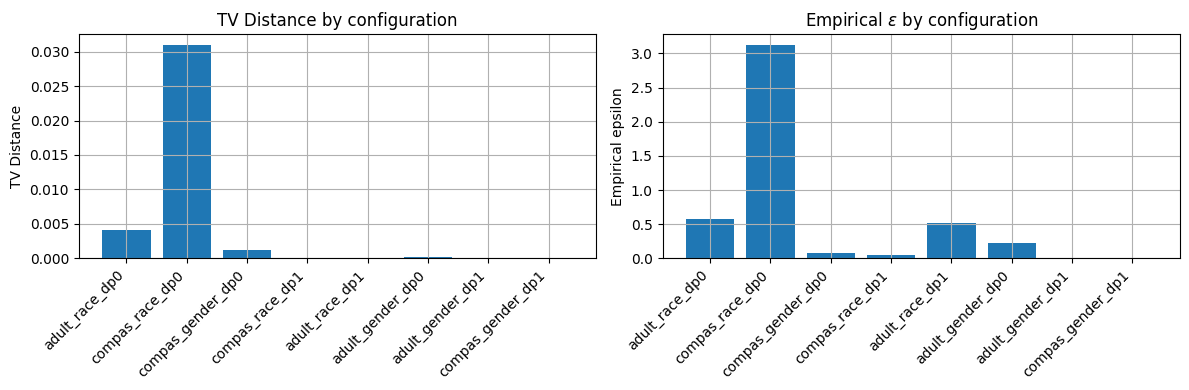

In [5]:
global_df = global_df.copy()
global_df["config"] = (
    global_df["dataset"] + "_" +
    global_df["protected_attr"] + "_dp" + global_df["dp"].astype(int).astype(str)
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]

sorted_idx = np.argsort(global_df["ks_pvalue"].values)
ax.bar(
    np.arange(len(global_df)),
    global_df["tv_distance"].values[sorted_idx]
)
ax.set_xticks(np.arange(len(global_df)))
ax.set_xticklabels(global_df["config"].values[sorted_idx], rotation=45, ha="right")
ax.set_ylabel("TV Distance")
ax.set_title("TV Distance by configuration")

ax = axes[1]
ax.bar(
    np.arange(len(global_df)),
    global_df["epsilon_empirical"].values[sorted_idx]
)
ax.set_xticks(np.arange(len(global_df)))
ax.set_xticklabels(global_df["config"].values[sorted_idx], rotation=45, ha="right")
ax.set_ylabel("Empirical epsilon")
ax.set_title("Empirical $\epsilon$ by configuration")

plt.tight_layout()
plt.savefig("plots/fairness_eval_metrics")
plt.show()


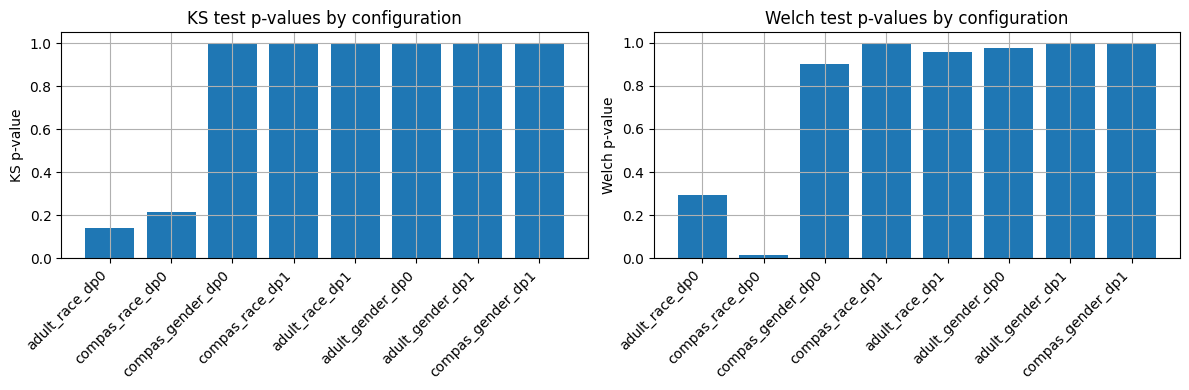

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]

ax.bar(
    np.arange(len(global_df)),
    global_df["ks_pvalue"].values[sorted_idx]
)
ax.set_xticks(np.arange(len(global_df)))
ax.set_xticklabels(global_df["config"].values[sorted_idx], rotation=45, ha="right")
ax.set_ylabel("KS p-value")
ax.set_title("KS test p-values by configuration")

ax = axes[1]

ax.bar(
    np.arange(len(global_df)),
    global_df["welch_t_pvalue"].values[sorted_idx]
)
ax.set_xticks(np.arange(len(global_df)))
ax.set_xticklabels(global_df["config"].values[sorted_idx], rotation=45, ha="right")
ax.set_ylabel("Welch p-value")
ax.set_title("Welch test p-values by configuration")

plt.tight_layout()
plt.savefig("plots/fairness_p_values")
plt.show()

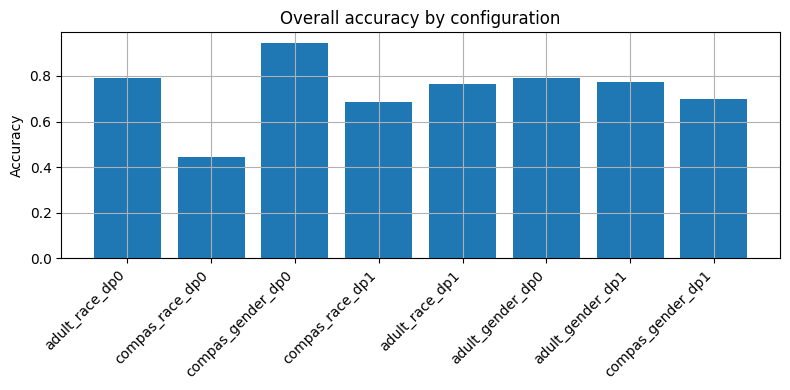

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(
    np.arange(len(global_df)),
    global_df["accuracy_overall"].values[sorted_idx]
)
ax.set_xticks(np.arange(len(global_df)))
ax.set_xticklabels(global_df["config"].values[sorted_idx], rotation=45, ha="right")
ax.set_ylabel("Accuracy")
ax.set_title("Overall accuracy by configuration")
plt.tight_layout()
plt.savefig("plots/fairness_accuracy")